# Car Price prediction

<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам
*Этот ноутбук является шаблоном (Baseline) к текущему соревнованию и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.


> **Baseline** создается больше как шаблон, где можно посмотреть, как происходит обращение с входящими данными и что нужно получить на выходе. При этом ML начинка может быть достаточно простой. Это помогает быстрее приступить к самому ML, а не тратить ценное время на инженерные задачи. 
Также baseline является хорошей опорной точкой по метрике. Если наше решение хуже baseline -  мы явно делаем что-то не так и стоит попробовать другой путь) 

## В baseline мы сделаем следующее:
* Построим "наивную"/baseline модель, предсказывающую цену по модели и году выпуска (с ней будем сравнивать другие модели)
* Обработаем и отнормируем признаки
* Сделаем первую модель на основе градиентного бустинга с помощью CatBoost
* Сделаем вторую модель на основе нейронных сетей и сравним результаты
* Сделаем multi-input нейронную сеть для анализа табличных данных и текста одновременно
* Добавим в multi-input сеть обработку изображений
* Осуществим ансамблирование градиентного бустинга и нейронной сети (усреднение их предсказаний)

In [8]:
#@title
!pip install numpy==1.19.5
!pip install -q tensorflow==2.3

  Using cached numpy-1.19.5-cp37-cp37m-manylinux2010_x86_64.whl (14.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.19.5 which is incompatible.
tensorflow 2.3.0 requires numpy<1.19.0,>=1.16.0, but you have numpy 1.19.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.18.5 which is incompatible.
tables 3.7.0 requires numpy>=1.19.0, but you have numpy 1.18.5 which is incompatible.
jaxlib 0.3.7+cuda11.cudnn805 requires numpy>=1.19, but you have numpy 1.18.5 which is incompatible.
jax 0.3.8 requires numpy>=1.19, but you have numpy 1.18.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [9]:
#@title
!pip install --upgrade albumentations
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor -q

In [10]:
#@title
!pip install catboost

In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations



# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [12]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.13 (default, Apr 24 2022, 01:04:09) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


In [13]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [14]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [15]:
!pip freeze > requirements.txt

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [16]:
from google.colab import files
files.upload()

{}

In [17]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!mkdir data
!kaggle competitions download -c 'sf-dst-car-price-prediction-part2'
!unzip sf-dst-car-price-prediction-part2.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/img/img/1099191536.jpg  
  inflating: data/img/img/1099192850.jpg  
  inflating: data/img/img/1099192962.jpg  
  inflating: data/img/img/1099193138.jpg  
  inflating: data/img/img/1099193234.jpg  
  inflating: data/img/img/1099193320.jpg  
  inflating: data/img/img/1099193756.jpg  
  inflating: data/img/img/1099193782.jpg  
  inflating: data/img/img/1099194660.jpg  
  inflating: data/img/img/1099195070.jpg  
  inflating: data/img/img/1099195074.jpg  
  inflating: data/img/img/1099197128.jpg  
  inflating: data/img/img/1099197154.jpg  
  inflating: data/img/img/1099197624.jpg  
  inflating: data/img/img/1099198042.jpg  
  inflating: data/img/img/1099198480.jpg  
  inflating: data/img/img/1099198516.jpg  
  inflating: data/img/img/1099199256.jpg  
  inflating: data/img/img/1099200028.jpg  
  inflating: data/img/img/1099200304.jpg  
  inflating: data/img/img/1099200554.jpg  
  inflating: data/img/img/1099200672.jpg  
  i

In [18]:
DATA_DIR = 'data/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [20]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [21]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [22]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == {row[1]}"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


# EDA

Проведем быстрый анализ данных для того, чтобы понимать, сможет ли с этими данными работать наш алгоритм.

Посмотрим, как выглядят распределения числовых признаков:

In [23]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

Итого:
* CatBoost сможет работать с признаками и в таком виде, но для нейросети нужны нормированные данные.

# PreProc Tabular Data

In [24]:
# #используем все текстовые признаки как категориальные без предобработки
# categorical_features = ['bodyType', 'brand', 'color', 'fuelType', 'model_info',
#   'numberOfDoors', 'vehicleTransmission', 'ПТС', 'Привод', 'Руль', 'Владельцы']

# #используем все числовые признаки
# numerical_features = ['mileage', 'modelDate', 'productionDate', 'engineDisplacement', 'enginePower', 'Владение']

In [25]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


In [26]:
num_cols = data.select_dtypes(include=[np.number]).columns
num_cols

Index(['mileage', 'modelDate', 'numberOfDoors', 'productionDate', 'sell_id',
       'sample', 'price'],
      dtype='object')

In [27]:
num_cols = num_cols.drop(['modelDate', 'numberOfDoors',  'sell_id', 'sample', 'price'])
num_cols = num_cols.tolist()

In [28]:
cat_cols = data.select_dtypes(include=[np.object]).columns
cat_cols

Index(['bodyType', 'brand', 'color', 'description', 'engineDisplacement',
       'enginePower', 'fuelType', 'model_info', 'name', 'vehicleConfiguration',
       'vehicleTransmission', 'Владельцы', 'Владение', 'ПТС', 'Привод',
       'Руль'],
      dtype='object')

In [29]:
data['bodyType'] = data['bodyType'].astype(str).apply(
    lambda x: None if x.strip() == '' else x)
data['bodyType'] = data.bodyType.apply(lambda x: x.split(' ')[0].lower())
data.bodyType.value_counts()

седан           3542
внедорожник     2905
купе             543
хэтчбек          421
лифтбек          299
универсал        196
минивэн          178
купе-хардтоп     111
родстер           88
кабриолет         54
компактвэн         8
лимузин            5
пикап              3
Name: bodyType, dtype: int64

In [30]:
data['Владельцы'].fillna('3 или более', inplace=True)

In [31]:
col = ['description','name', 'vehicleConfiguration','Владение', 'enginePower']
cat_cols = cat_cols.drop(col)

cat_cols = cat_cols.tolist()
cat_cols

['bodyType',
 'brand',
 'color',
 'engineDisplacement',
 'fuelType',
 'model_info',
 'vehicleTransmission',
 'Владельцы',
 'ПТС',
 'Привод',
 'Руль']

In [32]:
num_cols

['mileage', 'productionDate']

In [33]:
def get_ownership(row):
    '''Переформатирует из "1 год и 6 месяцев" в 1.5'''
    try:
        if (('год' in row) or ('лет' in row)) and ('месяц' in row):
            return int(row.split()[0])+(int(row.split()[3])/12)
        elif (('год' in row) or ('лет' in row)) and ('месяц' not in row):
            return int(row.split()[0])
        elif (('год' not in row) or ('лет' not in row)) and ('месяц' in row):
            return int(row.split()[0]) / 12
    except:
        return np.nan

In [34]:
def log_numerical(data, col):
  return np.log(data[col].max()+1 - data[col])

In [35]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def pca_cols(data, col1, col2):
    '''Объединяет 2 числовых признака в 1'''
    arrays = data[[col1, col2]].values
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(arrays)
    pca = PCA(n_components=1)
    pca.fit(scaled_data)
    pca_data = pca.transform(scaled_data)
    data[f'{col1}_{col2}_PCA'] = pca_data
    data = data.drop([col1, col2], axis=1)
    return data

In [36]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor df_output.'''
    
    df_output = df_input.copy()
    
    # # ################### 1. Предобработка ############################################################## 


    # ################### Numerical Features ############################################################## 

    # Нормализация данных
    scaler = RobustScaler()
    for column in num_cols:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    # for col in num_cols:
    #   df_output[col] = log_numerical(df_output, col)
    
    
    # ################### Categorical Features ############################################################## 
    # Label Encoding
    for column in cat_cols:
        df_output[column] = df_output[column].astype('category').cat.codes



    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, columns=cat_cols, dummy_na=False)
    
    
    # ################### Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # PCA
    # df_output = pca_cols(df_output, 'productionDate', 'modelDate')
    # df_output = pca_cols(df_output, 'engineDisplacement', 'enginePower')

    
    # признак - возраст модели:
    df_output['model_age'] = (2022 - df_output.modelDate)
    
    # признак - километраж за год
    df_output['mile_per_year'] = df_output['mileage'] / (2022 - df_output.modelDate)
       
    df_output['enginePower'] = df_output['enginePower'].apply(lambda x: x[:3]).astype('int')
    df_output['name_xDrive'] = df_output['name'].apply(lambda x: 1 if 'xDrive' in x else 0)
    
    
    # ################### Clean #################################################### 
    df_output.drop(['description','sell_id','name', 'vehicleConfiguration', 
                    'modelDate', 'Владение','numberOfDoors'], axis = 1, inplace=True)

    return df_output

In [37]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(10)

,enginePower,mileage,productionDate,sample,price,bodyType_0,bodyType_1,bodyType_2,bodyType_3,bodyType_4,...,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2,Руль_0,Руль_1,model_age,mile_per_year,name_xDrive
7399,245,-0.031380,0.285714,1,1590000.0,1,0,0,0,0,...,0,1,0,0,1,1,0,8,-0.003923,1
4273,245,-0.606317,0.428571,1,3100000.0,1,0,0,0,0,...,0,1,0,0,1,1,0,9,-0.067369,0
3362,585,-0.513585,0.285714,1,3750000.0,0,0,0,0,0,...,0,1,0,0,1,1,0,9,-0.057065,0
2794,245,0.135537,-0.285714,1,1990000.0,0,0,0,0,0,...,0,1,0,0,1,1,0,11,0.012322,0
5378,218,0.358093,0.285714,1,1285000.0,0,0,0,0,0,...,0,1,0,0,1,1,0,9,0.039788,1
5902,560,-0.376342,0.000000,1,3399999.0,0,0,0,0,0,...,0,1,0,0,1,1,0,10,-0.037634,0
1454,320,-0.534301,0.285714,0,0.0,0,0,0,0,0,...,0,1,0,0,1,1,0,10,-0.053430,1
2476,218,0.585285,-0.714286,1,700000.0,0,0,0,0,0,...,1,0,1,0,0,1,0,15,0.039019,0
743,115,0.089171,-0.428571,0,0.0,0,0,0,0,0,...,0,1,1,0,0,1,0,15,0.005945,0
1168,544,-0.689775,0.142857,0,0.0,1,0,0,0,0,...,0,1,0,0,1,1,0,10,-0.068978,0


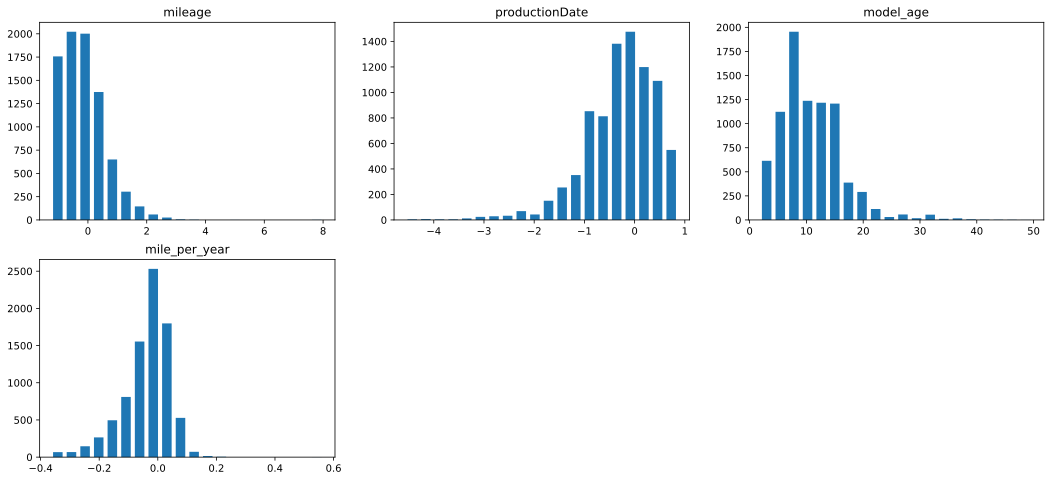

In [38]:
visualize_distributions({
    'mileage': df_preproc['mileage'].dropna(),
    #'modelDate': df_preproc['modelDate'].dropna(),
    'productionDate': df_preproc['productionDate'],
    'model_age': df_preproc['model_age'],
    'mile_per_year': df_preproc['mile_per_year'],
    #'engineDisplacement_enginePower_PCA': df_preproc['engineDisplacement_enginePower_PCA'],
})

In [39]:
def corr_matrix(data, det=True, pltx=10, plty=10):
    '''Funcion is called for making correlation matrix'''
    
    X = data.corr()
    if det:
        
        evals,evec = np.linalg.eig(X)
        ev_product = np.prod(evals)
    
        print(f'Rank of Matrix: {np.linalg.matrix_rank(X)}')
        print(f'Determinant of matrix: {np.round(ev_product,4)}')
        print(f'Shape of matrix: {np.shape(X)}')
    
    plt.figure(figsize=(pltx,plty))
    sns.heatmap(X,vmin=0,vmax=.9,annot=True,square=True)
    plt.show()

## Split data

In [40]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [41]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 227 entries, enginePower to name_xDrive
dtypes: float64(4), int64(3), uint8(220)
memory usage: 463.4 KB


# Model 2: CatBoostRegressor

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [43]:
model = CatBoostRegressor(iterations = 7000,
                          #depth=10,
                          #learning_rate = 0.5,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #task_type='GPU',
                         )
model.fit(X_train, np.log(y_train),
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=100,
         use_best_model=True,
         #plot=True
         )

Learning rate set to 0.020408
0:	learn: 0.0419734	test: 0.0420502	best: 0.0420502 (0)	total: 56.5ms	remaining: 6m 35s
100:	learn: 0.0141113	test: 0.0138238	best: 0.0138238 (100)	total: 332ms	remaining: 22.7s
200:	learn: 0.0108516	test: 0.0106086	best: 0.0106086 (200)	total: 581ms	remaining: 19.7s
300:	learn: 0.0100531	test: 0.0099120	best: 0.0099120 (300)	total: 880ms	remaining: 19.6s
400:	learn: 0.0096306	test: 0.0096098	best: 0.0096098 (400)	total: 1.3s	remaining: 21.3s
500:	learn: 0.0093243	test: 0.0093624	best: 0.0093624 (500)	total: 1.55s	remaining: 20.1s
600:	learn: 0.0090402	test: 0.0091603	best: 0.0091603 (600)	total: 1.81s	remaining: 19.3s
700:	learn: 0.0087189	test: 0.0089418	best: 0.0089418 (700)	total: 2.08s	remaining: 18.7s
800:	learn: 0.0084329	test: 0.0087276	best: 0.0087276 (800)	total: 2.37s	remaining: 18.3s
900:	learn: 0.0082162	test: 0.0085986	best: 0.0085986 (900)	total: 2.82s	remaining: 19.1s
1000:	learn: 0.0080332	test: 0.0084848	best: 0.0084848 (1000)	total: 3.14

In [44]:
test_predict_catboost = np.exp(model.predict(X_test))
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%") #12.23%

TEST mape: 11.15%


### Submission

In [45]:
sub_predict_catboost = np.round(np.exp(model.predict(X_sub)))
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

11.99% on sub

# Model 3: Tabular NN

Построим обычную сеть:

In [46]:
X_train.head(5)

,enginePower,mileage,productionDate,bodyType_0,bodyType_1,bodyType_2,bodyType_3,bodyType_4,bodyType_5,bodyType_6,...,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2,Руль_0,Руль_1,model_age,mile_per_year,name_xDrive
7320,544,0.367366,-0.285714,0,0,0,0,0,0,0,...,0,1,1,0,0,1,0,14,0.026240,0
8037,245,-0.829411,0.714286,1,0,0,0,0,0,0,...,0,1,0,0,1,1,0,6,-0.138235,0
4681,255,0.218040,-1.000000,0,0,0,0,0,0,0,...,0,1,0,0,1,1,0,18,0.012113,0
6014,184,2.036536,-0.857143,0,0,0,0,0,0,0,...,0,1,1,0,0,1,0,16,0.127284,0
3649,313,0.144810,0.000000,0,0,0,0,0,0,0,...,0,1,0,0,1,1,0,11,0.013165,1


## Simple Dense NN

In [47]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [48]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               116224    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 247,809
Trainable params: 247,809
Non-trainable params: 0
_________________________________________________________________


In [49]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [50]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### Fit

In [51]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

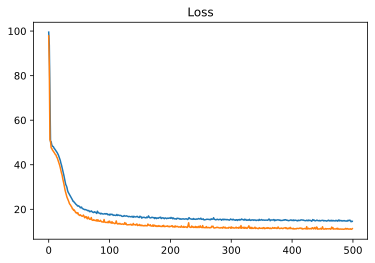

In [52]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [53]:
model.load_weights('best_model.hdf5')
model.save('nn_1.hdf5')

In [54]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%") #11.49%

TEST mape: 11.31%


In [55]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

11.7% on sub

# Model 4: NLP + Multiple Inputs

In [56]:
!pip install pymorphy2
import nltk
import pymorphy2
nltk.download("stopwords")

# https://pymorphy2.readthedocs.io/en/stable/

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [57]:
morph = pymorphy2.MorphAnalyzer()
patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"

In [58]:
def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        token = token.strip()
        token = morph.normal_forms(token)[0]
        tokens.append(token)
    return ' '.join(tokens)

In [59]:
df_preproc['description'] = data.description

In [60]:
df_preproc['description'] = df_preproc.apply(lambda df_preproc: lemmatize(df_preproc.description), axis=1)

In [61]:
df_preproc['description']

0       весь привет продать эксклюзивный проект универ...
1       продавать любимый тачил обвес и тюнинг потому ...
2       машина тут продаваться не в первый раз но толь...
3       автомобиль в отличный состояние весь в родный ...
4       немка с бесключивый доступ и камера задний вид...
                              ...                        
8348    продаваться любимый автомобиль за год эксплуат...
8349    купить у официальный дилер в г третий владелец...
8350    торг на место всё работать сборка немецкий рез...
8351    автомобиль в отличный состояние из авто в семь...
8352    удлинённый заводский на база вообще то правиль...
Name: description, Length: 8353, dtype: object

In [109]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [110]:
# split данных
text_train = df_preproc.description.iloc[X_train.index]
text_test = df_preproc.description.iloc[X_test.index]
text_sub = df_preproc.description.iloc[X_sub.index]

### Tokenizer

In [112]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(df_preproc.description)

CPU times: user 1.01 s, sys: 0 ns, total: 1.01 s
Wall time: 1 s


In [113]:
tokenize.word_index

{'•': 1,
 'в': 2,
 'и': 3,
 'с': 4,
 'автомобиль': 5,
 'на': 6,
 'не': 7,
 'по': 8,
 'система': 9,
 'всё': 10,
 'пробег': 11,
 'задний': 12,
 'салон': 13,
 'сидение': 14,
 'год': 15,
 'состояние': 16,
 'для': 17,
 'передний': 18,
 'машина': 19,
 'от': 20,
 'до': 21,
 'при': 22,
 'диск': 23,
 'у': 24,
 'комплект': 25,
 'дилер': 26,
 'новый': 27,
 'официальный': 28,
 'без': 29,
 'ваш': 30,
 'кредит': 31,
 'вы': 32,
 'фара': 33,
 'авто': 34,
 'быть': 35,
 'руль': 36,
 'пакет': 37,
 'колесо': 38,
 'безопасность': 39,
 'комплектация': 40,
 'за': 41,
 'гарантия': 42,
 'птс': 43,
 'обмен': 44,
 'контроль': 45,
 'то': 46,
 'зеркало': 47,
 'проверка': 48,
 'из': 49,
 'покупка': 50,
 'весь': 51,
 'два': 52,
 'продажа': 53,
 'водитель': 54,
 'более': 55,
 'полный': 56,
 'есть': 57,
 'шина': 58,
 'км': 59,
 'датчик': 60,
 'отличный': 61,
 'пассажир': 62,
 'двигатель': 63,
 'так': 64,
 'резина': 65,
 'мы': 66,
 'условие': 67,
 'владелец': 68,
 'только': 69,
 'ключ': 70,
 'один': 71,
 'хороший': 72,

In [114]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)
CPU times: user 941 ms, sys: 2.18 ms, total: 943 ms
Wall time: 939 ms


In [115]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

• автомобиль проверить по пункт • автокредит по специальный ставка от ауди центр север официальный дилер входящий в группа компания рольф и являться один из крупный дилер в европа предлагать вы ряд услуга по покупка и продажа автомобиль с пробег на протяжение многий год наш дилерский центр являться лидер по продажа автомобиль с пробег среди весь дилер в россия и предоставлять клиент самый большой выбор автомобиль с пробег и другой марка каждый автомобиль проходить тщательный диагностик и подготовка и гарантировать находиться в отличный состояние чтобы убедиться в правильный выбор у вы есть возможность пройти тест драйв ― ознакомительный поездка на интересовать автомобиль вы смочь ознакомиться с автомобиль не выходить из дом – наш менеджер провести презентация и в видеозвонок показать выбрать автомобиль также ауди центр север представлять уникальный предложение по кредитование автомобиль с пробег на индивидуальный условие специалист компания подобрать для вы хороший условие кредитование

### RNN NLP

In [116]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP

In [117]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

### Multiple Inputs NN

In [118]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [119]:
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 256, 256)     3673856     seq_description[0][0]            
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, 256, 256)     525312      embedding_3[0][0]                
__________________________________________________________________________________________________
dropout_13 (Dropout)            (None, 256, 256)     0           lstm_4[0][0]                     
_______________________________________________________________________________________

### Fit

In [121]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [122]:
checkpoint = ModelCheckpoint('best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [123]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 4s 307ms/step - loss: 99.0146 - MAPE: 99.0146 - val_loss: 93.2182 - val_MAPE: 93.2182
Epoch 2/500
12/12 [==============================] - 3s 251ms/step - loss: 72.1373 - MAPE: 72.1373 - val_loss: 51.3526 - val_MAPE: 51.3526
Epoch 3/500
12/12 [==============================] - 3s 246ms/step - loss: 52.7429 - MAPE: 52.7429 - val_loss: 50.2585 - val_MAPE: 50.2585
Epoch 4/500
12/12 [==============================] - 3s 246ms/step - loss: 50.1053 - MAPE: 50.1053 - val_loss: 47.1188 - val_MAPE: 47.1188
Epoch 5/500
12/12 [==============================] - 3s 262ms/step - loss: 48.6425 - MAPE: 48.6425 - val_loss: 47.2063 - val_MAPE: 47.2063
Epoch 6/500
12/12 [==============================] - 3s 247ms/step - loss: 48.1954 - MAPE: 48.1954 - val_loss: 45.2741 - val_MAPE: 45.2741
Epoch 7/500
12/12 [==============================] - 3s 247ms/step - loss: 46.5944 - MAPE: 46.5944 - val_loss: 44.4610 - val_MAPE: 44.4610
Epoch 8/500
12/12 [========

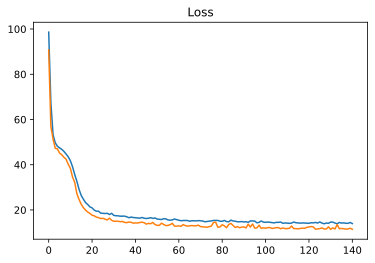

In [75]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [76]:
model.load_weights('best_model.hdf5')
model.save('nn_mlp_nlp.hdf5')

In [124]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%") #11.45%

TEST mape: 12.00%


In [78]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

Идеи для улучшения NLP части:
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например, сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста

# Model 5: Добавляем картинки

### Data

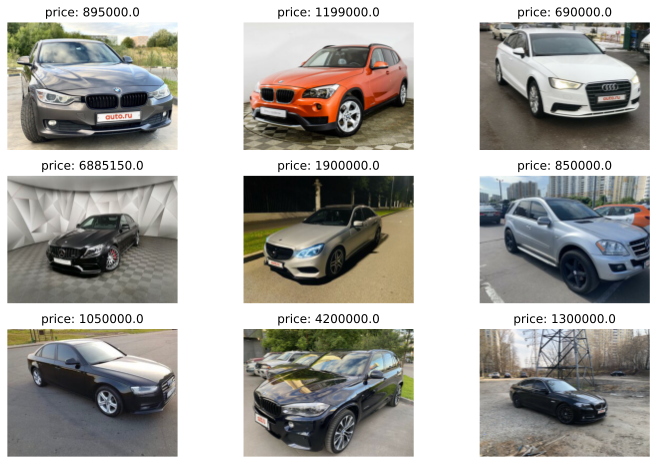

In [79]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [80]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


### albumentations

/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:290: FutureWarning: This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead
  warnings.warn("This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:165: FutureWarning: This augmentation is deprecated. Please use Emboss instead
  warnings.warn("This augmentation is deprecated. Please use Embo

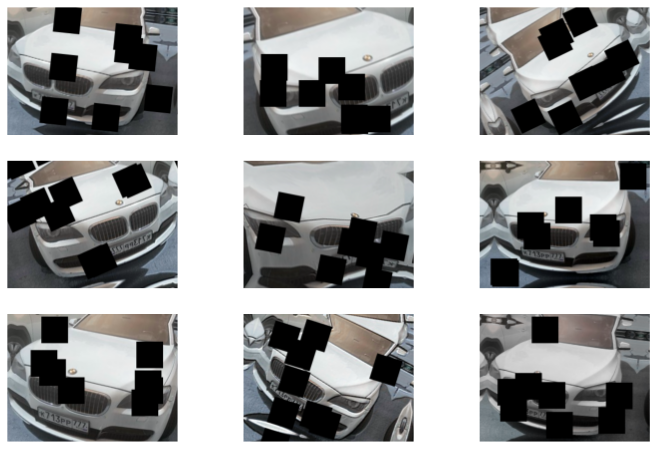

In [81]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, CoarseDropout, Rotate, 
)


augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    ], p=0.3),
    HueSaturationValue(p=0.3),
    CoarseDropout(p=1, max_height=50, max_width=50),
    Rotate(limit=30, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5)
], p=1)

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [82]:
def make_augmentations(images):
  print('применение аугментаций', end = '')
  augmented_images = np.empty(images.shape)
  for i in range(images.shape[0]):
    if i % 200 == 0:
      print('.', end = '')
    augment_dict = augmentation(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
  print('')
  return augmented_images

## tf.data.Dataset
Если все изображения мы будем хранить в памяти, то может возникнуть проблема ее нехватки. Не храните все изображения в памяти целиком!

Метод .fit() модели keras может принимать либо данные в виде массивов или тензоров, либо разного рода итераторы, из которых наиболее современным и гибким является [tf.data.Dataset](https://www.tensorflow.org/guide/data). Он представляет собой конвейер, то есть мы указываем, откуда берем данные и какую цепочку преобразований с ними выполняем. Далее мы будем работать с tf.data.Dataset.

Dataset хранит информацию о конечном или бесконечном наборе кортежей (tuple) с данными и может возвращать эти наборы по очереди. Например, данными могут быть пары (input, target) для обучения нейросети. С данными можно осуществлять преобразования, которые осуществляются по мере необходимости ([lazy evaluation](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BD%D0%B8%D0%B2%D1%8B%D0%B5_%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)).

`tf.data.Dataset.from_tensor_slices(data)` - создает датасет из данных, которые представляют собой либо массив, либо кортеж из массивов. Деление осуществляется по первому индексу каждого массива. Например, если `data = (np.zeros((128, 256, 256)), np.zeros(128))`, то датасет будет содержать 128 элементов, каждый из которых содержит один массив 256x256 и одно число.

`dataset2 = dataset1.map(func)` - применение функции к датасету; функция должна принимать столько аргументов, каков размер кортежа в датасете 1 и возвращать столько, сколько нужно иметь в датасете 2. Пусть, например, датасет содержит изображения и метки, а нам нужно создать датасет только из изображений, тогда мы напишем так: `dataset2 = dataset.map(lambda img, label: img)`.

`dataset2 = dataset1.batch(8)` - группировка по батчам; если датасет 2 должен вернуть один элемент, то он берет из датасета 1 восемь элементов, склеивает их (нулевой индекс результата - номер элемента) и возвращает.

`dataset.__iter__()` - превращение датасета в итератор, из которого можно получать элементы методом `.__next__()`. Итератор, в отличие от самого датасета, хранит позицию текущего элемента. Можно также перебирать датасет циклом for.

`dataset2 = dataset1.repeat(X)` - датасет 2 будет повторять датасет 1 X раз.

Если нам нужно взять из датасета 1000 элементов и использовать их как тестовые, а остальные как обучающие, то мы напишем так:

`test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)`

Датасет по сути неизменен: такие операции, как map, batch, repeat, take, skip никак не затрагивают оригинальный датасет. Если датасет хранит элементы [1, 2, 3], то выполнив 3 раза подряд функцию dataset.take(1) мы получим 3 новых датасета, каждый из которых вернет число 1. Если же мы выполним функцию dataset.skip(1), мы получим датасет, возвращающий числа [2, 3], но исходный датасет все равно будет возвращать [1, 2, 3] каждый раз, когда мы его перебираем.

tf.Dataset всегда выполняется в graph-режиме (в противоположность eager-режиму), поэтому либо преобразования (`.map()`) должны содержать только tensorflow-функции, либо мы должны использовать tf.py_function в качестве обертки для функций, вызываемых в `.map()`. Подробнее можно прочитать [здесь](https://www.tensorflow.org/guide/data#applying_arbitrary_python_logic).

In [83]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [84]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
  return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

### Строим сверточную сеть для анализа изображений без "головы"

In [85]:
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

43941888/43941136 [==============================] - 3s 0us/step


In [86]:
#строим нейросеть для анализа табличных данных
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'relu'),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.5),
    ])
    

In [87]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
    ])

In [88]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [89]:
optimizer = tf.keras.optimizers.Adam(0.001)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [90]:
checkpoint = ModelCheckpoint('best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [91]:
history = model.fit(train_dataset.batch(30),
                    epochs=100,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/100
190/190 [==============================] - 177s 930ms/step - loss: 66.7682 - MAPE: 66.7682 - val_loss: 50.9195 - val_MAPE: 50.9195
Epoch 2/100
190/190 [==============================] - 173s 909ms/step - loss: 47.6139 - MAPE: 47.6139 - val_loss: 45.6686 - val_MAPE: 45.6686
Epoch 3/100
190/190 [==============================] - 172s 905ms/step - loss: 46.3758 - MAPE: 46.3758 - val_loss: 43.8653 - val_MAPE: 43.8653
Epoch 4/100
190/190 [==============================] - 173s 908ms/step - loss: 45.1301 - MAPE: 45.1301 - val_loss: 42.4486 - val_MAPE: 42.4486
Epoch 5/100
190/190 [==============================] - 172s 905ms/step - loss: 42.4676 - MAPE: 42.4676 - val_loss: 38.0505 - val_MAPE: 38.0505
Epoch 6/100
190/190 [==============================] - 173s 909ms/step - loss: 38.2148 - MAPE: 38.2148 - val_loss: 33.1394 - val_MAPE: 33.1394
Epoch 7/100
190/190 [==============================] - 172s 907ms/step - loss: 32.6453 - MAPE: 32.6453 - val_loss: 27.0180 - val_MAPE: 27.0180

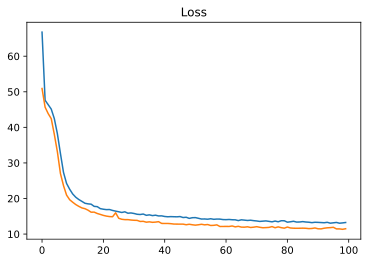

In [92]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [93]:
model.load_weights('best_model.hdf5')
model.save('nn_final.hdf5')

In [94]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 11.50%


In [95]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)


#### Общие рекомендации:
* Попробовать разные архитектуры
* Провести более детальный анализ результатов
* Попробовать различные подходы в управление LR и оптимизаторы
* Поработать с таргетом
* Использовать Fine-tuning

#### Tabular
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'). Можно удалить эти данные. Затем можно еще сильнее сократить размерность, например выделив наличие xDrive в качестве отдельного признака.

* Поработать над Feature engineering



#### NLP
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста



#### CV
* Попробовать различные аугментации
* Fine-tuning

# Blend

In [96]:
blend_predict = (test_predict_catboost + test_predict_nn3[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%") # 11.38%

TEST mape: 10.68%


In [108]:
test_predict_nn1.shap

(1003, 1)

In [97]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

# Model Bonus: проброс признака

In [100]:
# MLP
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

In [101]:
# FEATURE Input
# Iput
productiondate = L.Input(shape=[1], name="productiondate")
# Embeddings layers
emb_productiondate = L.Embedding(len(X.productionDate.unique().tolist())+1, 20)(productiondate)
f_productiondate = L.Flatten()(emb_productiondate)

In [102]:
combinedInput = L.concatenate([model_mlp.output, f_productiondate,])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_mlp.input, productiondate], outputs=head)

In [103]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_13_input (InputLayer)     [(None, 226)]        0                                            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 512)          116224      dense_13_input[0][0]             
__________________________________________________________________________________________________
dropout_11 (Dropout)            (None, 512)          0           dense_13[0][0]                   
__________________________________________________________________________________________________
productiondate (InputLayer)     [(None, 1)]          0                                            
_______________________________________________________________________________________

In [104]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [106]:
#@title
history = model.fit([X_train, X_train.productionDate.values], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([X_test, X_test.productionDate.values], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500


InvalidArgumentError: ignored

In [ ]:
model.load_weights('best_model.hdf5')
test_predict_nn_bonus = model.predict([X_test, X_test.productionDate.values])
print(f"TEST mape: {(mape(y_test, test_predict_nn_bonus[:,0]))*100:0.2f}%")

Final score: 11.21%